In [1]:
import numpy as np # linear algebra
import pandas as pd # train processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
sns.set(color_codes=True)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold



/Users/briner/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/briner/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))


gender_submission.csv
test.csv
train.csv



In [3]:
rng = np.random.RandomState(4711)

train = pd.read_csv('../input/train.csv')

print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test = pd.read_csv('../input/test.csv')

print(test.shape)
test.head()



(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
prediction = pd.DataFrame(test['PassengerId'], columns=['PassengerId'])

prediction.head()

,PassengerId
0,892
1,893
2,894
3,895
4,896


# Visualize training data

## Plotting functions

In [6]:
def plot_correlation_heatmap(data):
    corr = data.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )    
    


def plot_distribution(data, feature_col_name, target_col_name):
    survived = train.loc[train[target_col_name] == 1, feature_col_name].dropna().sort_values().values
    not_survived = train.loc[train[target_col_name] == 0, feature_col_name].dropna().sort_values().values

    plt.figure(figsize=(15,7))
    sns.distplot(survived, hist = False)
    sns.distplot(not_survived, color='red', hist= False)
    sns.plt.title(feature_col_name)
    sns.plt.xlabel(feature_col_name)
    plt.show()
       
        
def plot_scatter(data, feature1_col_name, feature2_col_name, target_col_name):
    
    plt.figure(figsize=(15,7))
    plt.scatter(train.loc[train[target_col_name] == 1, feature1_col_name],
                train.loc[train[target_col_name] == 1, feature2_col_name])
    plt.scatter(train.loc[train[target_col_name] == 0, feature1_col_name],
                train.loc[train[target_col_name] == 0, feature2_col_name],color='r')
    plt.legend((target_col_name +' = 1', target_col_name +' = 0'))
    plt.title(feature1_col_name + ' vs '+ feature2_col_name)
    plt.xlabel(feature1_col_name)
    plt.ylabel(feature2_col_name)
    plt.show()
    
def plot_categorical_feature(data, categorical_feature_columns, target_col_name):
    plt.figure(figsize=(15,20))

    for idx, feature_col_name in enumerate(categorical_feature_columns):

        values = data[feature_col_name].unique()
        values.sort(axis=0)    
        ind = np.arange(len(values))

        survived = data.loc[data[target_col_name] == True].groupby(feature_col_name).agg('count')[target_col_name]
        not_survived = data.loc[data[target_col_name] == False].groupby(feature_col_name).agg('count')[target_col_name]

        for value in values:
            if (value not in survived.index.unique()):
                survived[value] = 0
            if (value not in not_survived.index.unique()):
                not_survived[value] = 0

        plt.subplot(round(len(categorical_feature_columns)/2)+1,2,idx+1)  

        plt.bar(ind, survived)
        plt.bar(ind, not_survived, color='r', bottom=survived)
        plt.xticks(ind,values)
        plt.legend(('survived', 'not survived'))
        plt.title(feature_col_name)
    plt.show


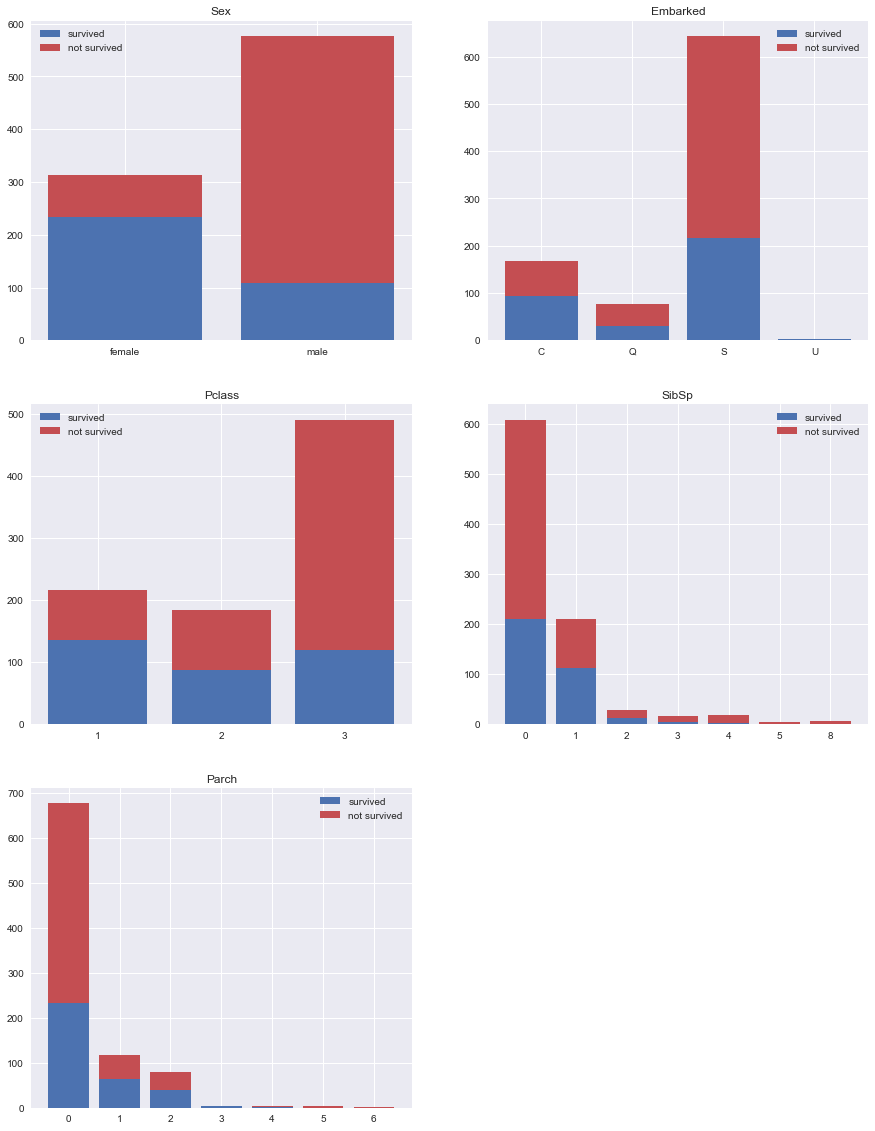

In [7]:
train['Embarked'].fillna('U', inplace=True)

plot_categorical_feature(train, ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch'], 'Survived')

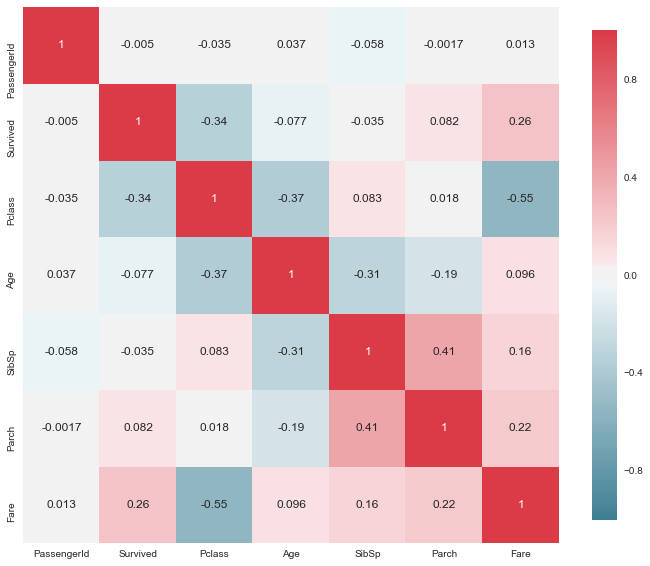

In [8]:
plot_correlation_heatmap(train)

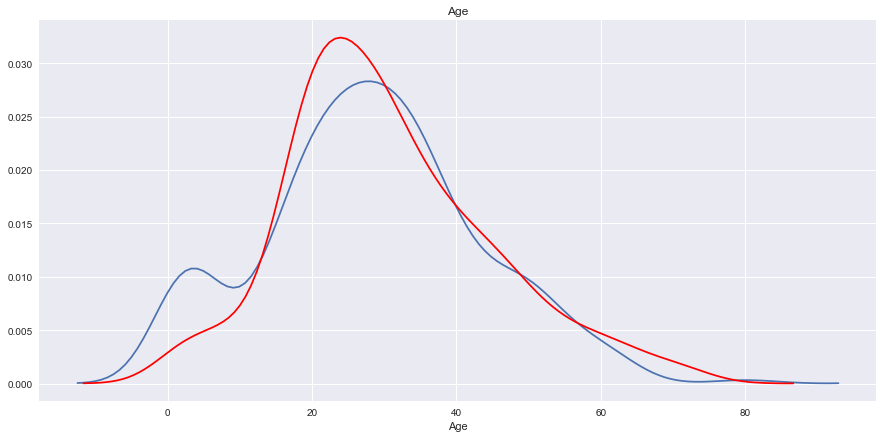

In [9]:
plot_distribution(train, 'Age', 'Survived')

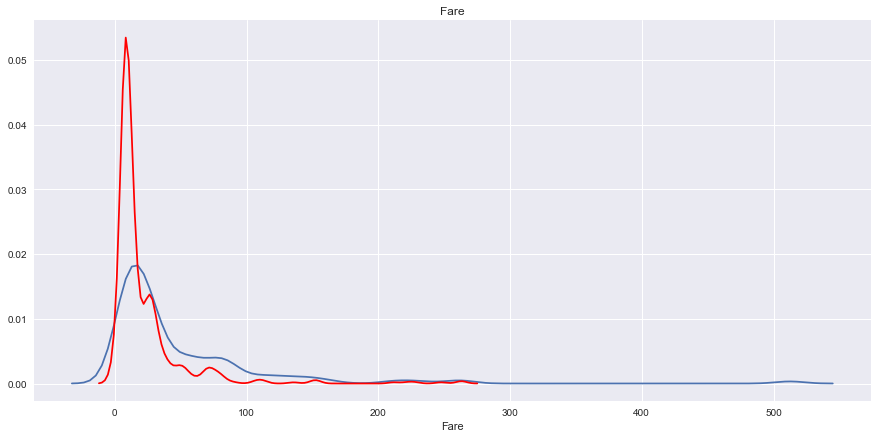

In [10]:
plot_distribution(train, 'Fare', 'Survived')

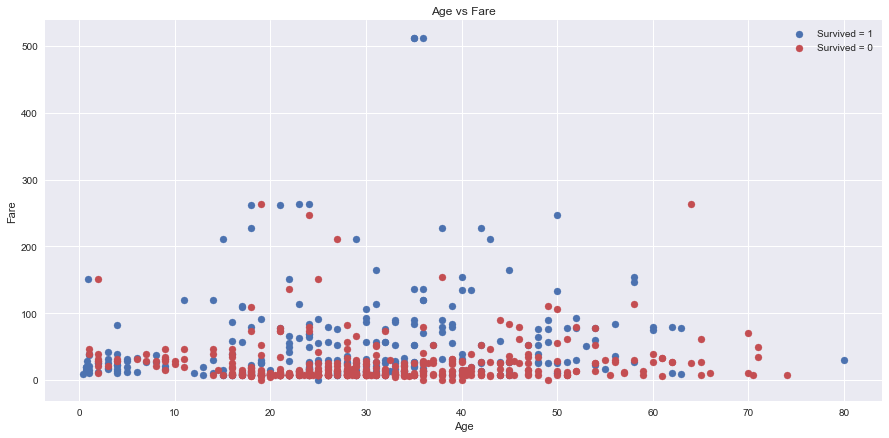

In [11]:
plot_scatter(train,'Age', 'Fare', 'Survived')


# Preprocess data

In [12]:
remove_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train = train.drop(remove_columns, axis = 1)
print(train.shape)
train.head()


(891, 8)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [13]:
test = test.drop(remove_columns, axis = 1)
print(test.shape)
test.head()


(418, 7)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


## Prepare Embarked

In [14]:
labelencoder = LabelEncoder()
onehotencoder = OneHotEncoder()


train['Embarked'].fillna('U', inplace=True)
embarked_values = train['Embarked'].unique()
embarked_values.sort(axis=0)

train['Embarked'] = labelencoder.fit_transform(train['Embarked'])
embarked_onehot = onehotencoder.fit_transform(train['Embarked'].values.reshape(-1,1))

embarked_columns = pd.DataFrame(embarked_onehot.todense())
embarked_columns.iloc[:,0:-1]

train[embarked_values[:-1]] = embarked_columns.iloc[:,0:-1]
train = train.drop(['Embarked'], axis = 1)

print(train.shape)
train.head()

(891, 10)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,male,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,female,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,female,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,female,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,male,35.0,0,0,8.0500,0.0,0.0,1.0


In [15]:

test['Embarked'].fillna('U', inplace=True)
embarked_values = test['Embarked'].unique()
embarked_values.sort(axis=0)

test['Embarked'] = labelencoder.fit_transform(test['Embarked'])
embarked_onehot = onehotencoder.fit_transform(test['Embarked'].values.reshape(-1,1))

embarked_columns = pd.DataFrame(embarked_onehot.todense())
embarked_columns.iloc[:,0:-1]

test[embarked_values[0:]] = embarked_columns
test = test.drop(['Embarked'], axis = 1)

print(test.shape)
test.head()

(418, 9)


,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,3,male,34.5,0,0,7.8292,0.0,1.0,0.0
1,3,female,47.0,1,0,7.0000,0.0,0.0,1.0
2,2,male,62.0,0,0,9.6875,0.0,1.0,0.0
3,3,male,27.0,0,0,8.6625,0.0,0.0,1.0
4,3,female,22.0,1,1,12.2875,0.0,0.0,1.0


## Prepare Sex

In [16]:
train['Sex'].fillna('U', inplace=True)
sex_values = train['Sex'].unique()
sex_values.sort(axis=0)

train['Sex'] = labelencoder.fit_transform(train['Sex'])

print(train.shape)
train.head()

(891, 10)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,1,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,0,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,0,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,0,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0


In [17]:
test['Sex'].fillna('U', inplace=True)
sex_values = test['Sex'].unique()
sex_values.sort(axis=0)

test['Sex'] = labelencoder.fit_transform(test['Sex'])

print(test.shape)
test.head()

(418, 9)


,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,3,1,34.5,0,0,7.8292,0.0,1.0,0.0
1,3,0,47.0,1,0,7.0000,0.0,0.0,1.0
2,2,1,62.0,0,0,9.6875,0.0,1.0,0.0
3,3,1,27.0,0,0,8.6625,0.0,0.0,1.0
4,3,0,22.0,1,1,12.2875,0.0,0.0,1.0


## Prepare Age

In [18]:
age_mean = train['Age'].mean()
train['Age'] = train['Age'].fillna(age_mean)


In [19]:
test['Age'] = test['Age'].fillna(age_mean)

## Prepare Fare

In [20]:
fare_mean = train['Fare'].mean()
train['Fare'] = train['Fare'].fillna(fare_mean)


In [21]:
test['Fare'] = test['Fare'].fillna(fare_mean)


# Use Random Forest Model

In [22]:
print(train.shape)
train = train.dropna()
print(train.shape)
train.head()

(891, 10)
(891, 10)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,1,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,0,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,0,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,0,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0


In [23]:
y = train['Survived']
print(y.shape)
y.head()

(891,)


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [24]:
X = train.drop(['Survived'], axis = 1)
print(X.shape)
X.head()

(891, 9)


,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,3,1,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,0,38.0,1,0,71.2833,1.0,0.0,0.0
2,3,0,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,0,35.0,1,0,53.1000,0.0,0.0,1.0
4,3,1,35.0,0,0,8.0500,0.0,0.0,1.0


In [25]:


param_grid = {
                 'n_estimators': [5, 10, 15, 20, 30],
                 'max_depth': [2, 5, 7, 9, 13]
             }

clf = RandomForestClassifier(random_state=rng)


grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X, y)

best_clf = grid_clf.best_estimator_

best_clf


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x118435360>,
            verbose=0, warm_start=False)

In [26]:

scores = cross_val_score(best_clf, X, y, cv=10)
print(scores.mean())

0.829521620701


# select features

Optimal number of features : 4


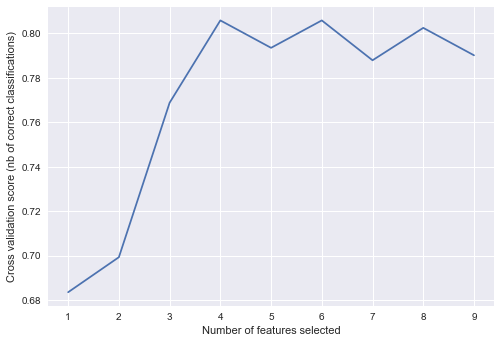

[(1, 'Age'), (1, 'Fare'), (1, 'Pclass'), (1, 'Sex'), (2, 'SibSp'), (3, 'Parch'), (4, 'S'), (5, 'C'), (6, 'Q')]


In [ ]:


names = X.columns


rfecv = RFECV(estimator=best_clf, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print (sorted(zip(map(lambda x: round(x, 4), rfecv.ranking_), names)))

In [ ]:
optimal_feature_selection = ['Age', 'Fare', 'Pclass', 'Sex']

X = X[optimal_feature_selection]
test = test[optimal_feature_selection]

param_grid = {
                 'n_estimators': [5, 10, 15, 20, 30],
                 'max_depth': [2, 5, 7, 9, 13]
             }

clf = RandomForestClassifier(random_state=rng)


grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X, y)

best_clf = grid_clf.best_estimator_

best_clf


In [ ]:

scores = cross_val_score(best_clf, X, y, cv=10)
print(scores.mean())

In [ ]:
y_pred = best_clf.predict(test)

In [ ]:
prediction['Survived'] = y_pred
print(prediction.shape)
prediction.head()

In [ ]:
prediction.to_csv('../output/Titanic.csv', index=False)